In [672]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('max_columns', 500)

In [673]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [674]:
def print_metrics(label, pred):
    print('Accuracy: ', accuracy_score(label, pred))
    print('Precision: ', precision_score(label, pred))
    print('Recall: ', recall_score(label, pred))
    print('F1: ', f1_score(label, pred))
    print('AUC: ', roc_auc_score(label, pred))

In [675]:
tracker = pd.DataFrame(columns = ['train_acc','train_prec','train_rec','train_f1','train_auc','test_acc','test_prec',
                                 'test_rec','test_f1','test_auc'])
model_list = []

In [676]:
def update_tracker(model,name, y_train, y_hat_train, y_test, y_hat_test):
    train_acc = accuracy_score(y_train, y_hat_train)
    train_prec = precision_score(y_train, y_hat_train)
    train_rec = recall_score(y_train, y_hat_train)
    train_f1 = f1_score(y_train, y_hat_train)
    train_auc = roc_auc_score(y_train, y_hat_train)
    
    test_acc = accuracy_score(y_test, y_hat_test)
    test_prec = precision_score(y_test, y_hat_test)
    test_rec = recall_score(y_test, y_hat_test)
    test_f1 = f1_score(y_test, y_hat_test)
    test_auc = roc_auc_score(y_test, y_hat_test)
    
    model_list.append(model)
    
    tracker.loc[name] = [train_acc, train_prec, train_rec, train_f1, train_auc, test_acc, test_prec, test_rec, test_f1, test_auc]

In [677]:
df = pd.read_csv('preprocessed.csv',index_col=0)

# KNN with upsampling

In [678]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=0)

In [679]:
training = pd.concat([X_train, y_train],axis=1)

In [680]:
churn = training[training['Churn']==1]
no_churn = training[training['Churn']==0]

In [681]:
from sklearn.utils import resample

In [682]:
# upsample minority
churn_upsampled = resample(churn,
                          replace=True, # sample with replacement
                          n_samples=len(no_churn), # match number in majority class
                          random_state=23) # reproducible results

In [683]:
# combine majority and upsampled minority
upsampled = pd.concat([no_churn, churn_upsampled])

In [684]:
y_train = upsampled['Churn']
X_train = upsampled.drop(['Churn'],axis=1)

In [685]:
for i in range(15,30,2):
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1, p=5)
    knn.fit(X_train, y_train)

    y_hat_train = knn.predict(X_train)
    y_hat_test = knn.predict(X_test)
    
    update_tracker(knn,'knn_up_'+str(i),y_train, y_hat_train, y_test, y_hat_test)
    print(i)

15
17
19
21
23
25
27
29


In [686]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052


# Decision Tree Weighted

In [687]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

In [688]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=0)

In [689]:
dtc1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,class_weight='balanced')
dtc1.fit(X_train, y_train)

y_hat_train = dtc1.predict(X_train)
y_hat_test = dtc1.predict(X_test)

In [690]:
update_tracker(dtc1,'dtc1',y_train, y_hat_train, y_test, y_hat_test)

In [691]:
tracker.head(40)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593


In [692]:
# Load libraries
from sklearn.metrics import make_scorer


In [693]:
from sklearn import tree

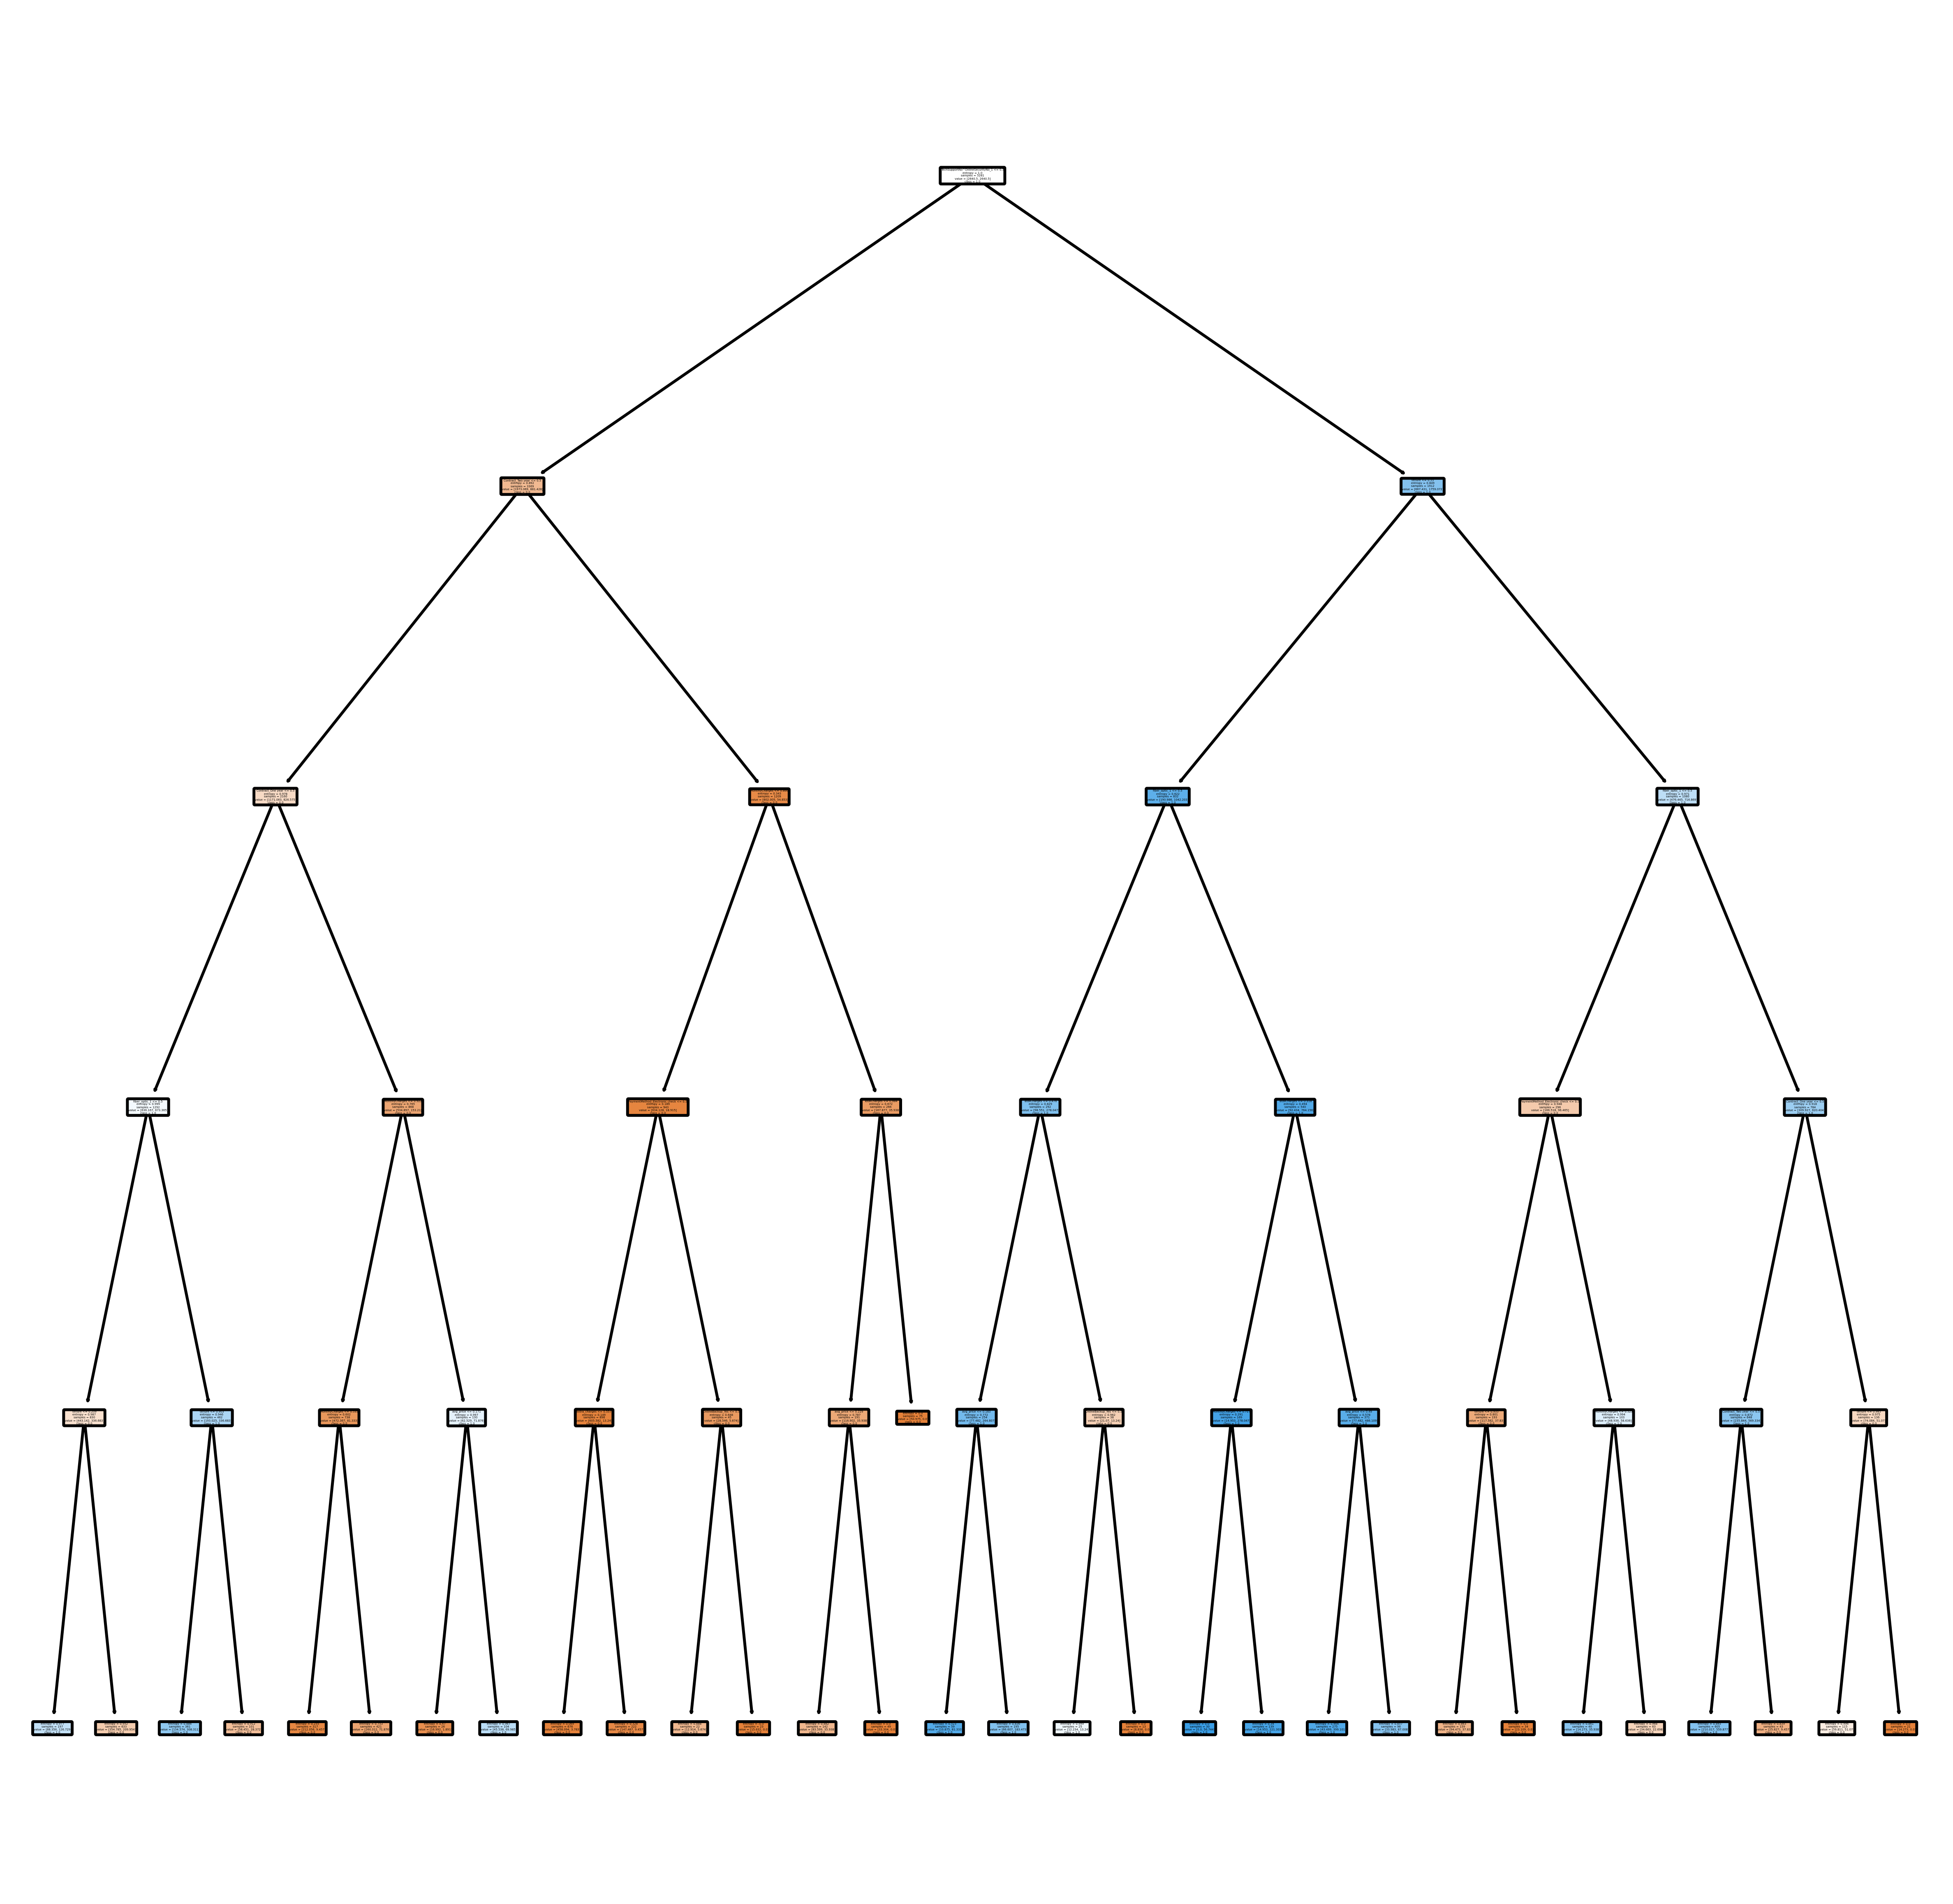

In [694]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(dtc1, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

In [695]:
dtc1.feature_importances_

array([0.11824583, 0.07544269, 0.02506479, 0.        , 0.02943306,
       0.00520341, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00755202, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.08497314,
       0.1818843 , 0.        , 0.        , 0.01540522, 0.        ,
       0.07110274, 0.        , 0.        , 0.        , 0.        ,
       0.3856928 ])

In [696]:
feature_importance = pd.DataFrame(sorted(list(zip(X.columns,dtc1.feature_importances_)),key= lambda x: x[1]),columns=['feature','importance'])

In [697]:
feature_importance

,feature,importance
0,services,0.000000
1,gender_Male,0.000000
2,SeniorCitizen_1,0.000000
3,PhoneService_Yes,0.000000
4,MultipleLines_No phone service,0.000000
5,MultipleLines_Yes,0.000000
6,InternetService_Yes,0.000000
7,OnlineSecurity_No internet service,0.000000
8,OnlineSecurity_Yes,0.000000
9,OnlineBackup_No internet service,0.000000


# DTC GridsearchCV

In [698]:
from sklearn.model_selection import GridSearchCV

In [699]:
#create a dictionary of all the parameters you want to tune
param_grid = {
    'criterion': ['entropy','gini'],
    'max_depth': range(3,10)
    
}

In [700]:
#create a grid search object and fit it to the data

grid_dtc=GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, scoring='f1', verbose=1)

In [701]:
grid_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.9s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(3, 10)},
             scoring='f1', verbose=1)

In [702]:
y_hat_train = grid_dtc.predict(X_train)
y_hat_test = grid_dtc.predict(X_test)

In [703]:
update_tracker(grid_dtc,'grid_dtc',y_train, y_hat_train, y_test, y_hat_test)

In [704]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


In [705]:
grid_dtc.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}

# Random Forest

In [706]:
#scaling data
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [707]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=0)

In [708]:
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth = 5,random_state=0,class_weight='balanced')
rfc.fit(X_train,y_train)

y_hat_train = rfc.predict(X_train)
y_hat_test = rfc.predict(X_test)

In [709]:
update_tracker(rfc,'rfc', y_train, y_hat_train, y_test, y_hat_test)

In [710]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


In [711]:
feature_importance = pd.DataFrame(sorted(list(zip(X.columns,rfc.feature_importances_)),key= lambda x: x[1]),columns=['feature','importance'])
feature_importance

,feature,importance
0,TechSupport_No internet service,0.000000
1,OnlineBackup_Yes,0.000244
2,StreamingMovies_Yes,0.000317
3,gender_Male,0.000618
4,PaymentMethod_Mailed check,0.000680
5,StreamingTV_No internet service,0.000754
6,SeniorCitizen_1,0.001020
7,family_status_Family,0.001132
8,family_status_SingleParent,0.001651
9,PaymentMethod_Credit card (automatic),0.001687


# Voting Classifier

In [712]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=0)

In [713]:
training = pd.concat([X_train, y_train],axis=1)

In [714]:
churn = training[training['Churn']==1]
no_churn = training[training['Churn']==0]

In [715]:
# upsample minority
churn_upsampled = resample(churn,
                          replace=True, # sample with replacement
                          n_samples=len(no_churn), # match number in majority class
                          random_state=23) # reproducible results

In [716]:
# combine majority and upsampled minority
upsampled = pd.concat([no_churn, churn_upsampled])

In [717]:
y_train = upsampled['Churn']
X_train = upsampled.drop(['Churn'],axis=1)

In [718]:
from sklearn.ensemble import VotingClassifier
clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = KNeighborsClassifier(n_neighbors=9)
clf4 = KNeighborsClassifier(n_neighbors=11)
clf5 = KNeighborsClassifier(n_neighbors=13)
clf6 = KNeighborsClassifier(n_neighbors=15)
clf7 = LogisticRegressionCV(solver='liblinear', class_weight = 'balanced', penalty='l1', max_iter=1000)
clf8 = RandomForestClassifier(n_estimators=100, max_depth=5, max_features='log2')
clf9 = DecisionTreeClassifier(class_weight='balanced') 
eclf1 = VotingClassifier(estimators=[('kn1', clf1), ('kn2', clf2), ('kn3', clf3), ('kn4', clf4),('kn5', clf5),
                                    ('kn6', clf6),('log', clf7),('rfc', clf8),('dtc', clf9)], voting='hard')
eclf1.fit(X_train, y_train)
y_hat_train = eclf1.predict(X_train)
y_hat_test = eclf1.predict(X_test)

In [719]:
update_tracker(eclf1,'eclf1', y_train, y_hat_train, y_test, y_hat_test)

In [720]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


# Bagging

In [721]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

In [722]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [723]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.25, random_state=0)

In [724]:
from sklearn.ensemble import BaggingClassifier

In [725]:
bc_lr = BaggingClassifier(
            base_estimator=LogisticRegression(solver = 'liblinear',random_state = 0, class_weight='balanced', penalty='l1', max_iter=1000),
    n_estimators= 100,
    oob_score= True,bootstrap_features=True)

In [726]:
bc_lr.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                    max_iter=1000, penalty='l1',
                                                    random_state=0,
                                                    solver='liblinear'),
                  bootstrap_features=True, n_estimators=100, oob_score=True)

In [727]:
# Use the oob_score to get some idea of how the model performs on a validation set

bc_lr.oob_score_

0.7583790948683962

In [728]:
y_hat_train = bc_lr.predict(X_train)
y_hat_test = bc_lr.predict(X_test)

In [729]:
update_tracker(bc_lr,'bc_lr', y_train, y_hat_train, y_test, y_hat_test)

In [730]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


# XG Boost upsampled

In [731]:
#import the appropriate packages
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [732]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

In [733]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [734]:
training = pd.concat([X_train, y_train],axis=1)

In [735]:
churn = training[training['Churn']==1]
no_churn = training[training['Churn']==0]

In [736]:
# upsample minority
churn_upsampled = resample(churn,
                          replace=True, # sample with replacement
                          n_samples=len(no_churn), # match number in majority class
                          random_state=23) # reproducible results

In [737]:
# combine majority and upsampled minority
upsampled = pd.concat([no_churn, churn_upsampled])

In [738]:
y_train = upsampled['Churn']
X_train = upsampled.drop(['Churn'],axis=1)

In [739]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           booster='gbtree',
                           colsample_bytree = .1, 
                           subsample = .1,
                           learning_rate = 0.5,
                           max_depth = 1,
                           min_child_weight=10,
                           alpha = 5,
                           gamma = .1,
                           n_estimators = 1500,
                          random_state=0)

In [740]:
xg_clf.fit(X_train,y_train)

y_hat_train = xg_clf.predict(X_train)
y_hat_test = xg_clf.predict(X_test)

In [741]:
update_tracker(xg_clf,'xg_clf', y_train, y_hat_train, y_test, y_hat_test)

In [742]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


# XGBoost Downsampled

In [743]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

In [744]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [745]:
training = pd.concat([X_train, y_train],axis=1)

In [746]:
churn = training[training['Churn']==1]
no_churn = training[training['Churn']==0]

In [747]:
# upsample minority
no_churn_downsampled = resample(no_churn,
                          replace=True, # sample with replacement
                          n_samples=len(churn), # match number in majority class
                          random_state=23) # reproducible results

In [748]:
downsampled = pd.concat([churn, no_churn_downsampled])

In [749]:
y_train = downsampled['Churn']
X_train = downsampled.drop(['Churn'],axis=1)

In [750]:
xg_down = xgb.XGBClassifier(objective ='binary:logistic', 
                           booster='dart',
                           colsample_bytree = .1, 
                           subsample = .1,
                           learning_rate = 0.1,
                           max_depth = 1, 
                           alpha = 5, 
                           n_estimators = 1500)

In [751]:
xg_down.fit(X_train,y_train)

y_hat_train = xg_down.predict(X_train)
y_hat_test = xg_down.predict(X_test)

In [752]:
update_tracker(xg_down,'xg_down', y_train, y_hat_train, y_test, y_hat_test)

In [753]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


# Light GBM

In [754]:
from lightgbm import LGBMClassifier

In [755]:
y = df['Churn']
X = df.drop(['Churn'],axis=1)

In [756]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [757]:
training = pd.concat([X_train, y_train],axis=1)

In [758]:
churn = training[training['Churn']==1]
no_churn = training[training['Churn']==0]

In [759]:
# upsample minority
churn_upsampled = resample(churn,
                          replace=True, # sample with replacement
                          n_samples=len(no_churn), # match number in majority class
                          random_state=23) # reproducible results

In [760]:
# combine majority and upsampled minority
upsampled = pd.concat([no_churn, churn_upsampled])

In [761]:
y_train = upsampled['Churn']
X_train = upsampled.drop(['Churn'],axis=1)

In [762]:
#LightGBM
lgbm_clf = LGBMClassifier(drop_rate=0.9, min_data_in_leaf=800, max_bin=500,
                         n_estimators=5000, min_sum_hessian_in_leaf=1, importance_type='gain',
                         learning_rate=0.4, bagging_fraction=0.9, colsample_bytree=1.0,
                         feature_fraction=0.1, lambda_l1=5.0, lambda_l2=3.0, max_depth=9,
                         min_child_samples=55, min_child_weight=5.0, min_split_gain=0.1,
                         num_leaves=4000, subsample = 0.75)

In [763]:
lgbm_clf.fit(X_train,y_train)

y_hat_train = lgbm_clf.predict(X_train)
y_hat_test = lgbm_clf.predict(X_test)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=5.0 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.75 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0


In [764]:
update_tracker(lgbm_clf,'lgbmc_clf', y_train, y_hat_train, y_test, y_hat_test)

In [765]:
tracker.head(50)

,train_acc,train_prec,train_rec,train_f1,train_auc,test_acc,test_prec,test_rec,test_f1,test_auc
knn_up_15,0.786873,0.743926,0.874903,0.804116,0.786873,0.696763,0.462668,0.799154,0.586047,0.729158
knn_up_17,0.785071,0.743139,0.871300,0.802133,0.785071,0.699602,0.465937,0.809725,0.591506,0.734443
knn_up_19,0.778764,0.739284,0.861261,0.795625,0.778764,0.702442,0.469166,0.820296,0.596923,0.739729
knn_up_21,0.777992,0.737990,0.862033,0.795204,0.777992,0.701306,0.467801,0.813953,0.594136,0.736946
knn_up_23,0.779923,0.740651,0.861519,0.796525,0.779923,0.701874,0.468293,0.811839,0.593968,0.736665
knn_up_25,0.779151,0.737986,0.865637,0.796731,0.779151,0.693924,0.460337,0.809725,0.586973,0.730561
knn_up_27,0.772716,0.732296,0.859717,0.790907,0.772716,0.687677,0.453670,0.797040,0.578221,0.722278
knn_up_29,0.772072,0.730786,0.861519,0.790786,0.772072,0.692220,0.458182,0.799154,0.582435,0.726052
dtc1,0.762166,0.532926,0.811605,0.643384,0.778003,0.746167,0.517906,0.794926,0.627189,0.761593
grid_dtc,0.813293,0.657209,0.613897,0.634815,0.749419,0.776263,0.587973,0.558140,0.572668,0.707253


In [766]:
other_tracker = tracker[['train_f1','test_f1']]

In [771]:
logreg_tracker = pd.read_csv('logreg_results.csv',index_col=0)

In [772]:
results = pd.concat([logreg_tracker, other_tracker])

In [775]:
results

,train_f1,test_f1
logreg_df_base,0.607820,0.573113
logreg_base,0.603187,0.586572
logreg_weight,0.640771,0.628667
logreg_up,0.779593,0.633530
logreg_down,0.781705,0.621262
logreg_smote,0.789513,0.632378
logreg_tomek,0.666160,0.619149
logreg_base_lasso,0.603187,0.586572
logreg_weight_lasso,0.639456,0.625736
logreg_up_lasso,0.780117,0.625839


In [803]:
np.arange(1,logreg_tracker.shape[0]+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [791]:
np.linspace(1,31,32)

array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
        5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
       10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
       15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
       20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
       25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
       30.03225806, 31.        ])

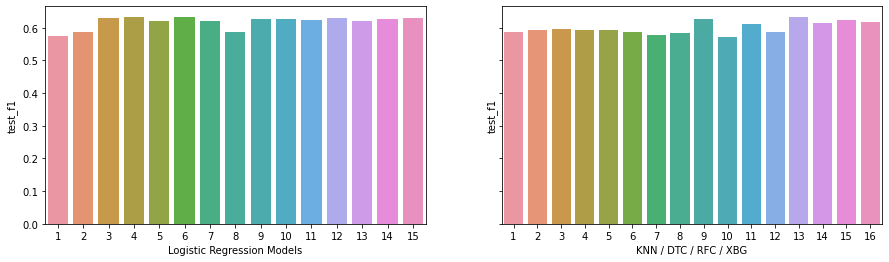

In [811]:
fig, axes = plt.subplots(1,2,sharey=True,figsize=(15,4))
sns.barplot(x=np.arange(1,logreg_tracker.shape[0]+1),y='test_f1',data=logreg_tracker, ax=axes[0])
axes[0].set_xlabel('Logistic Regression Models')
sns.barplot(x=np.arange(1,other_tracker.shape[0]+1),y='test_f1',data=other_tracker, ax=axes[1])
axes[1].set_xlabel('KNN / DTC / RFC / XBG')
fig.savefig('model_performance.png')